# Model

In [15]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import tensorflow as tf
import numpy as np
import os
from six.moves import cPickle as pickle

## Reading data

In [2]:
# This function reads one record from the binary files
def read_binary(filename_queue):
    label_bytes = 6     # Labels contain: Number of digits + 5 digits
    img_height = 32
    img_width = 32
    img_channels = 3
    image_bytes = img_height * img_width * img_channels
    
    # Every record consists of a label followed by the image, with a fixed number of bytes for each.
    record_bytes = label_bytes + image_bytes
    reader = tf.FixedLengthRecordReader(record_bytes=record_bytes)
    key, value = reader.read(filename_queue)
    record_bytes = tf.decode_raw(value, tf.int8)

    label = tf.cast(tf.slice(record_bytes, [0], [label_bytes]),tf.int32)
    image = tf.cast(tf.reshape(tf.slice(record_bytes, [label_bytes], [image_bytes]),[img_height, img_width, img_channels]), tf.float32)
    
    # To gray scale
    image = tf.image.rgb_to_grayscale(image)
    
    # Apply random brightness/contrast transformations
    if (np.random.random_sample()>0.5):
        image = tf.image.random_brightness(image, max_delta=63)
        image = tf.image.random_contrast(image,lower=0.2, upper=1.8)
    else:
        image = tf.image.random_contrast(image,lower=0.2, upper=1.8)
        image = tf.image.random_brightness(image, max_delta=63)
    
    # Subtract mean
    image = tf.subtract(image, tf.reduce_mean(image))

    return image, label   

# This function create training batches running processes in parallel
def input_pipeline(filenames, batch_size, num_epochs=None):
    num_preprocess_threads = 2
    
    filename_queue = tf.train.string_input_producer(filenames, num_epochs=num_epochs, shuffle=True)
    example_list = [read_binary(filename_queue) for _ in range(num_preprocess_threads)]

    label, image = read_binary(filename_queue)
    min_after_dequeue = 2000
    capacity = min_after_dequeue + 3 * batch_size

    image_batch, label_batch = tf.train.shuffle_batch_join(
        example_list, batch_size=batch_size, capacity=capacity,
        min_after_dequeue=min_after_dequeue)

    return image_batch, label_batch

In [3]:
def load_valid_test(num_valid, num_test, filename):
    with open(filename, 'rb') as f:
        save = pickle.load(f)
        valid_dataset = save['valid_dataset']
        valid_labels = save['valid_labels']
        test_dataset = save['test_dataset']
        test_labels = save['test_labels']
        del save
    
    for i in range(num_valid):
        temp = tf.cast(tf.constant(valid_dataset[i,:,:,:]),tf.float32)
        # To gray scale
        temp = tf.image.rgb_to_grayscale(temp)    
        # Subtract mean
        temp = tf.subtract(temp, tf.reduce_mean(temp))
        if i==0:
            result = tf.expand_dims(temp, 0)
        else:
            result = tf.concat([result, tf.expand_dims(temp, 0)], 0)

    valid_dataset = result
    valid_labels = tf.cast(valid_labels[:num_valid],tf.int32)
    
    for i in range(num_test):
        temp = tf.cast(tf.constant(test_dataset[i,:,:,:]),tf.float32)
        # To gray scale
        temp = tf.image.rgb_to_grayscale(temp)    
        # Subtract mean
        temp = tf.subtract(temp, tf.reduce_mean(temp))
        if i==0:
            result = tf.expand_dims(temp, 0)
        else:
            result = tf.concat([result, tf.expand_dims(temp, 0)], 0)

    test_dataset = result
    test_labels = tf.cast(test_labels[:num_test],tf.float32)
    
    return valid_dataset, valid_labels, test_dataset, test_labels

## Metrics

In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

## Architecture

In [5]:
num_labels = 11 # 0-9, + blank 
num_channels = 1

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64

# Binary files where the training data was stored
file_names = ['Train%d.bin' % i for i in range(1,4)]
# Pickle file where validation and testing were stored
valid_test_file_name = 'SVHN.pickle'
# Number of Valid/Testing samples to load into memory
num_valid = 1000
num_test = 2000

In [6]:
graph = tf.Graph()

with graph.as_default():
    # Input data.
    tf_train_dataset, tf_train_labels = input_pipeline(file_names, batch_size, num_epochs=None)   
    tf_valid_dataset, tf_valid_labels, tf_test_dataset, test_labels = load_valid_test(num_valid, num_test, valid_test_file_name)

    # Variables.
    layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
    layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
    layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

    s1_w = tf.get_variable("WS1", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS1')
    s2_w = tf.get_variable("WS2", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS2')
    s3_w = tf.get_variable("WS3", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS3')
    s4_w = tf.get_variable("WS4", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS4')
    s5_w = tf.get_variable("WS5", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    s5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS5')
  

    def model(data, keep_prob):
        conv = tf.nn.conv2d(data,layer1_weights, [1,1,1,1],padding='VALID', name='C1')
        hidden = tf.nn.relu(conv + layer1_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S2')
        conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
        hidden = tf.nn.relu(conv + layer2_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S4')
        conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')
        hidden = tf.nn.relu(conv + layer3_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])

        logits1 = tf.matmul(reshape, s1_w) + s1_b
        logits2 = tf.matmul(reshape, s2_w) + s2_b
        logits3 = tf.matmul(reshape, s3_w) + s3_b
        logits4 = tf.matmul(reshape, s4_w) + s4_b
        logits5 = tf.matmul(reshape, s5_w) + s5_b
        return [logits1, logits2, logits3, logits4, logits5]
  
    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.9375)
    # Define loss function.
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,1], logits=logits1)) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,2], logits=logits2)) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,3], logits=logits3)) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,4], logits=logits4)) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,5], logits=logits5))
    
    # Optimizer.
    global_step = tf.Variable(0)
    #learning rate with exponential decay.
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95) 
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.stack([tf.nn.softmax(model(tf_train_dataset, 1.0)[0]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0)[1]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0)[2]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0)[3]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0)[4])])
    valid_prediction = tf.stack([tf.nn.softmax(model(tf_valid_dataset, 1.0)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0)[4])])
    test_prediction = tf.stack([tf.nn.softmax(model(tf_test_dataset, 1.0)[0]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0)[1]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0)[2]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0)[3]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0)[4])])
    saver = tf.train.Saver()
    
    print('Ready')

Ready


## Training

In [12]:
num_steps = 20000                               # Number of training steps
savename = "./SVHN_Model.ckpt"    # Where to save the final model
with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())  
#     summary_writer = tf.summary.FileWriter('TensorBoard/svhn_train',session.graph)
    
    # These are required to start the processes reading training batches
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=session, coord=coord)
    
    # Load existing models if available
    if os.path.exists(savename):
        reader = tf.train.NewCheckpointReader(savename)
        reader.get_variable_to_shape_map()
        saver.restore(session, savename)
        print('Model restored.')

    print('Initialized')
    
    for step in range(num_steps):
        _, l, predictions, batch_labels = session.run([optimizer, loss, train_prediction, tf_train_labels])
        
        # Save logs
#         if step%100 == 50:
#             summary_str, gbl_step = session.run([summary_op, global_step])
#             summary_writer.add_summary(summary_str, gbl_step)
        
        # Prints minibatch accuracy
        if (step % 500 == 0): 
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,1:]))
           
        # Prints validation accuracy and saves current model
        if step%1000 == 0 or (step+1) == num_steps:
            saver.save(session, savename)
            val_prediction, valid_label = session.run([valid_prediction, tf_valid_labels])
            print('Validation accuracy: %.1f%%' % accuracy(val_prediction, valid_label[:,1:]))    
    
    # Gets testing set and its labels
    test_dataset, labels_test, prediction_test = session.run([tf_test_dataset, test_labels, test_prediction])
    # Accuracy on testing set
    print('Test accuracy: %.1f%%' % accuracy(prediction_test, labels_test[:,1:]))
    # Save final model
    save_path = saver.save(session, savename)
    print("Model saved in file: %s" % save_path) 
    
    gbl_step = session.run(global_step)
    print("Total number of training steps: %d" % gbl_step)    
    coord.request_stop()
    coord.join(threads)

    session.close()

Initialized
Minibatch loss at step 0: 16.922565
Minibatch accuracy: 7.2%
Validation accuracy: 54.4%
Minibatch loss at step 500: 6.346472
Minibatch accuracy: 55.9%
Minibatch loss at step 1000: 5.208951
Minibatch accuracy: 67.2%
Validation accuracy: 68.3%
Minibatch loss at step 1500: 4.152069
Minibatch accuracy: 77.2%
Minibatch loss at step 2000: 4.148127
Minibatch accuracy: 75.6%
Validation accuracy: 74.1%
Minibatch loss at step 2500: 4.058958
Minibatch accuracy: 75.9%
Minibatch loss at step 3000: 3.607552
Minibatch accuracy: 79.4%
Validation accuracy: 77.2%
Minibatch loss at step 3500: 3.577070
Minibatch accuracy: 74.7%
Minibatch loss at step 4000: 3.167928
Minibatch accuracy: 80.6%
Validation accuracy: 79.6%
Minibatch loss at step 4500: 3.401225
Minibatch accuracy: 80.3%
Minibatch loss at step 5000: 3.026673
Minibatch accuracy: 83.1%
Validation accuracy: 80.9%
Minibatch loss at step 5500: 2.734197
Minibatch accuracy: 81.6%
Minibatch loss at step 6000: 3.551112
Minibatch accuracy: 82.2

## Evaluate

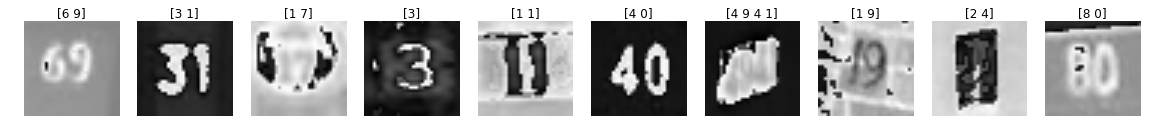

In [13]:
from PIL import Image
import sys
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

im_samples = []
labels_test = labels_test.astype(int)  
for i,j in enumerate(np.sort(np.random.randint(0, labels_test.shape[0], size = 10))):
    im_samples.extend([j])
    ax[i].axis('off')
    label = labels_test[j,1:1+labels_test[j,0]]
    ax[i].set_title(label, loc='center')
    ax[i].imshow(test_dataset[j,:,:,0],cmap="gray")

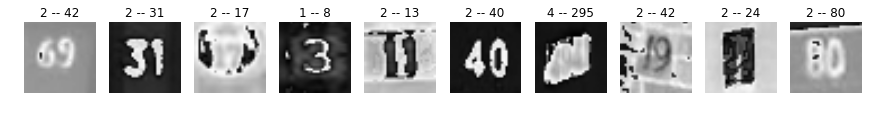

In [14]:
temp = np.transpose(np.argmax(prediction_test,axis=2))
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(im_samples):
    ax[i].axis('off')
    label = str(labels_test[j,0]) + " -- "
    for digit in temp[j,:]:
        if digit==10:
            break
        else:
            label += str(digit)
    ax[i].set_title(label, loc='center')
    ax[i].imshow(test_dataset[j,:,:,0],cmap="gray")